In [2]:
import re

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.plot import *
from matplotlib import patches
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap, Normalize

In [3]:
from matplotlib import rc
labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Gene metadata

In [4]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

tf_genes = pd.read_csv(
    '/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv',
    index_col=0)
tf_genes = set(','.join(tf_genes['EnsemblID'].dropna()).split(','))
gene_meta['is_tf'] = gene_meta.index.map(lambda i: i.split('.')[0] in tf_genes)

zfp_pattern = r'Zfp\d+'
p = re.compile(zfp_pattern)
gene_meta.loc[gene_meta['gene_name'].apply(lambda i: p.search(i) is not None
                                           ), 'is_tf'] = True
tf_gene_names = set(gene_meta[gene_meta['is_tf']]['gene_name'].tolist())

In [5]:
remove_gene_pattern = r'(Gm\d+)|(.+Rik)'
p = re.compile(remove_gene_pattern)

keep_gene = gene_meta[
    gene_meta['gene_name'].apply(lambda i: p.search(i) is None)].index

## Cell Tidy Data

In [6]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data = cell_tidy_data[cell_tidy_data['CellClass'] == 'Inh']
cell_tidy_data = cell_tidy_data[
    cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
subtype_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()

## Tree and gene assignment

In [8]:
dendro = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.dendrogram.lib'
)
linkage = pd.read_csv(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.linkage.csv',
    index_col=0)
node_dict = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.non_singleton_node_dict.lib'
)
gene_assignment = pd.read_msgpack(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/InhGeneToTree/NodeGeneResults.msg'
)
gene_assignment = gene_assignment.loc[:,
                                      gene_assignment.columns.isin(keep_gene
                                                                   )].copy()
gene_assignment.columns = gene_assignment.columns.map(gene_meta['gene_name'])

In [9]:
tf_gene_assignment = gene_assignment.loc[:,
                                         gene_assignment.columns.
                                         isin(tf_gene_names)]
other_gene_assignment = gene_assignment.loc[:, ~gene_assignment.columns.
                                            isin(tf_gene_names)]

## Normalize linkage height to 0-1

In [10]:
linkage['2'] = linkage['2'] / linkage['2'].max()

## Plot

In [11]:
rs_abs_min = 0.3

records = tf_gene_assignment.unstack().reset_index()
records.columns = ['gene', 'node', 'relevant_score']
use_data = records[records['relevant_score'].abs() > rs_abs_min].reset_index(
    drop=True)
use_data['relevant_score_abs'] = use_data['relevant_score'].abs()

n_leaves = len(dendro['ivl'])
node_height = linkage['2'].copy()
node_height.index = node_height.index
use_data['node_height'] = use_data['node'].map(node_height).reset_index(
    drop=True)
use_data.head()
print(use_data.shape)

use_data['impact'] = use_data['relevant_score_abs'] * use_data['node_height']
total_rs_data = use_data.groupby('gene')['impact'].sum().sort_values()

tf_total_data = use_data
tf_sum_rs = total_rs_data

(2872, 5)


In [12]:
records = other_gene_assignment.unstack().reset_index()
records.columns = ['gene', 'node', 'relevant_score']
use_data = records[records['relevant_score'].abs() > rs_abs_min].reset_index(
    drop=True)
use_data['relevant_score_abs'] = use_data['relevant_score'].abs()

n_leaves = len(dendro['ivl'])
node_height = linkage['2'].copy()
node_height.index = node_height.index
use_data['node_height'] = use_data['node'].map(node_height).reset_index(
    drop=True)
use_data.head()
print(use_data.shape)

use_data['impact'] = use_data['relevant_score_abs'] * use_data['node_height']
total_rs_data = use_data.groupby('gene')['impact'].sum().sort_values()

other_total_data = use_data
other_sum_rs = total_rs_data

(35844, 5)


In [13]:
from adjustText import adjust_text

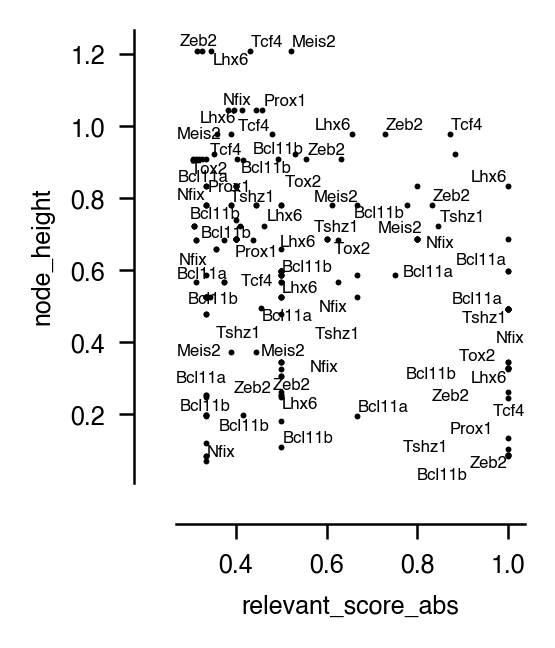

In [14]:
fig, ax = plt.subplots(figsize=(1.5, 2), dpi=300)

sns.scatterplot(data=use_data,
                ax=ax,
                s=2,
                color='k',
                linewidth=0,
                x='relevant_score_abs',
                y='node_height')

texts = []
plot_names = use_data['gene'].value_counts()[:10].index
for _, row in use_data.iterrows():
    if row['gene'] not in plot_names:
        continue
    t = ax.text(row['relevant_score_abs'],
                row['node_height'],
                row['gene'],
                ha='center',
                va='center',
                fontsize=4)
    texts.append(t)

adjust_text(texts)

sns.despine(ax=ax, offset=10)

## TF genes

In [14]:
tf_sum_rs.sort_values(ascending=False)[:10]

gene
Tshz1     7.628918
Cux1      6.955053
Tox2      6.647957
Rora      6.319589
Zbtb16    6.297957
Sox6      6.193888
Zfp462    6.060450
Zfp704    5.976938
Bcl11b    5.911439
Mef2c     5.839244
Name: impact, dtype: float64

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


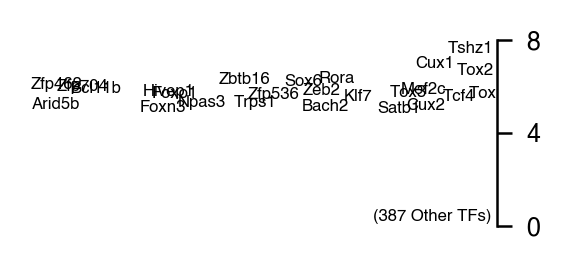

In [15]:
from matplotlib import patches
import numpy as np

label_y_cutoff = 5

df = tf_sum_rs[tf_sum_rs > label_y_cutoff]
other_count = tf_sum_rs[tf_sum_rs <= label_y_cutoff].size
df[f'({other_count} Other TFs)'] = 0.2

# c=[groupColors.get(langnameGroup[label],'k') for label in df.index]
fig = plt.figure(figsize=(2, 1), dpi=300)
gs = fig.add_gridspec(1, 10)

ax = fig.add_subplot(gs[0, :])
# ax_scatter = fig.add_subplot(gs[0, 9:])

ax.axes.get_xaxis().set_visible(False)
ax.set_xlim(-40, 0.1)
ax.set_ylim(0, 8)
ax.set_yticks([0, 4, 8])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')

plt.tight_layout()

patch = patches.Rectangle((-0.1, 0), 0.2, 100, fill=False, alpha=0)
# We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

texts = []
np.random.seed(0)
for label, y in zip(df.index, df):
    texts += [
        ax.text(
            -.1 + np.random.random() / 1000,
            y + np.random.random() / 1000,
            label,
            # A small random shift prevents labels
            # which have exactly the same coordinates from being stuck together
            # (not a problem in this example really, but wanted to mention this possibility)
            color='k',
            fontsize=4)
    ]
adjust_text(
    texts,
    [0 for _ in df],
    df,
    ha='left',
    va='center',
    add_objects=[patch],
    expand_text=(1.05, 1),
    # We want them to be quite compact, so reducing expansion makes sense
    force_text=(0.75, 0),
    force_objects=(1, 0),
    #With default forces it takes a very long time to converge,
    # but higher values still produce very nice output
    autoalign=False,
    only_move={
        'points': 'x',
        'text': 'x',
        'objects': 'x'
    })

fig.savefig('Inh.TF.total_rs.strip_plot.text_part.pdf', bbox_inches='tight')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/seaborn/utils.py:238: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  maj_on = any(t.tick1On for t in ax_i.yaxis.majorTicks)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/seaborn/utils.py:239: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  min_on = any(t.tick1On for t in ax_i.yaxis.minorTicks)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/seaborn/utils.py:242: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = maj_on
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/seaborn/utils.py:244: MatplotlibDeprecationWarning: 
The tick2On fun

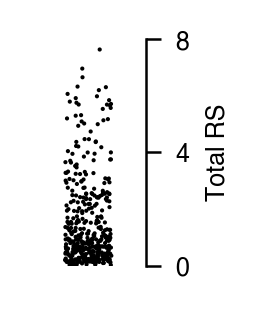

In [16]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=300)
sns.stripplot(y=tf_sum_rs, jitter=0.2, s=1, color='k')
sns.despine(ax=ax, bottom=True, left=True, right=False)
ax.set_ylabel('Total RS')
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')
ax.set_ylim(0, 8)
ax.set_yticks([0, 4, 8])

ax.set_xticks([])

fig.savefig('Inh.TF.total_rs.strip_plot.scatter_part.pdf')

## Other genes

In [17]:
other_sum_rs.describe()

count    5975.000000
mean        1.297980
std         1.314515
min         0.017052
25%         0.339810
50%         0.789177
75%         1.843306
max         7.314931
Name: impact, dtype: float64

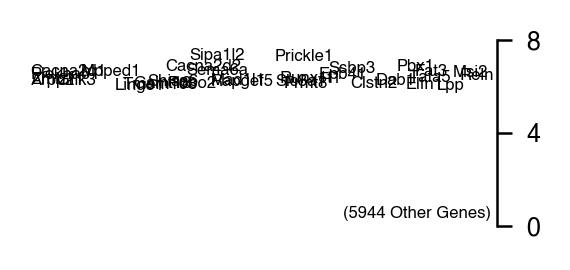

In [18]:
from matplotlib import patches
import numpy as np

label_y_cutoff = 6

df = other_sum_rs[other_sum_rs > label_y_cutoff]
other_count = other_sum_rs[other_sum_rs <= label_y_cutoff].size
df[f'({other_count} Other Genes)'] = 0.5

# c=[groupColors.get(langnameGroup[label],'k') for label in df.index]
fig = plt.figure(figsize=(2, 1), dpi=300)
gs = fig.add_gridspec(1, 10)

ax = fig.add_subplot(gs[0, :])
# ax_scatter = fig.add_subplot(gs[0, 9:])

ax.axes.get_xaxis().set_visible(False)
ax.set_xlim(-40, 0.1)
ax.set_ylim(0, 8)

ax.set_yticks([0, 4, 8])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')

plt.tight_layout()

patch = patches.Rectangle((-0.1, 0), 0.2, 100, fill=False, alpha=0)
# We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

texts = []
np.random.seed(0)
for label, y in zip(df.index, df):
    texts += [
        ax.text(
            -.1 + np.random.random() / 1000,
            y + np.random.random() / 1000,
            label,
            # A small random shift prevents labels
            # which have exactly the same coordinates from being stuck together
            # (not a problem in this example really, but wanted to mention this possibility)
            color='k',
            fontsize=4)
    ]
adjust_text(
    texts,
    [0 for _ in df],
    df,
    ha='left',
    va='center',
    add_objects=[patch],
    expand_text=(1.05, 1),
    # We want them to be quite compact, so reducing expansion makes sense
    force_text=(0.75, 0),
    force_objects=(1, 0),
    #With default forces it takes a very long time to converge,
    # but higher values still produce very nice output
    autoalign=False,
    only_move={
        'points': 'x',
        'text': 'x',
        'objects': 'x'
    })

fig.savefig('Inh.Other.total_rs.strip_plot.text_part.pdf', bbox_inches='tight')

In [19]:
other_sum_rs.max()

7.314931336189734

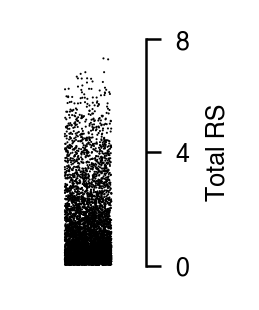

In [20]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=300)
# other_sum_rs[other_sum_rs > 2.5] = 2.5
sns.stripplot(y=other_sum_rs, jitter=0.2, s=0.5, color='k', clip_on=False)
sns.despine(ax=ax, bottom=True, left=True, right=False)
ax.set_ylabel('Total RS')
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')
ax.set_ylim(0, 8)
ax.set_yticks([0, 4, 8])
ax.set_xticks([])

fig.savefig('Inh.Other.total_rs.strip_plot.scatter_part.pdf',
            bbox_inches='tight')

In [21]:
tf_sum_rs.to_csv('inh.tf.sum_rs.csv', header=False)
other_sum_rs.to_csv('inh.other.sum_rs.csv', header=False)

## Relationship between exc and inh

In [22]:
exc_tf_rs = pd.read_csv('exc.tf.sum_rs.csv', header=None, index_col=0, squeeze=True)
exc_other_rs = pd.read_csv('exc.other.sum_rs.csv', header=None, index_col=0, squeeze=True)


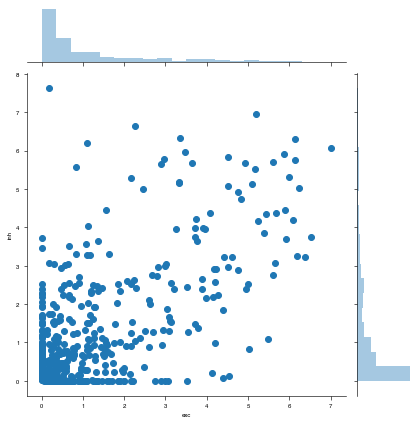

In [23]:
total = pd.DataFrame([exc_tf_rs, tf_sum_rs]).T.fillna(0)
total.columns=['exc', 'inh']

sns.jointplot(data=total, x='exc', y='inh')

In [29]:
total[(total['exc'] > 5) & (total['inh'] > 5)]

,exc,inh
Bach2,5.088050,5.128860
Tcf4,5.156774,5.530305
Cux1,5.180611,6.955053
Tox3,5.593268,5.706958
Bcl11b,5.863160,5.911439
Trps1,5.998122,5.310341
Zbtb16,6.124371,6.297957
Hivep1,6.127094,5.747911
Satb1,6.228843,5.016221
Zfp462,7.016831,6.060450
